# Stroke Prediction and EDA

### **Table of Contents**
* [<span style="color:#A690A4"> 0. Executive Summary](#exe_sum)
* [<span style="color:#A690A4"> 1. Introduction](#intro)
* [<span style="color:#A690A4"> 2. Collect, Wrangle & Explore Data](#process)
* [<span style="color:#A690A4"> 3. Predict Asking Price](#predict)
* [<span style="color:#A690A4"> 4. Conclusion](#conclusion)

# <span style="color:#5E6997">Executive Summary</span> <a class="anchor" id="exe_sum"></a>

# <span style="color:#5E6997">Introduction</span> <a class="anchor" id="intro"></a>

## General Approach

**Do Before Splitting:**
1. ✓ Address missing values.
2. ✓ Address outliers.
3. ✓ Irrelevant feature removal.

**Do After Splitting:**
1. ✓ One-Hot Encoding.
2. ✓ Imputation.
3. Feature engineering.
4. Feature selection.
5. ✓ Scaling.

Here are some recommended models and methodologies based on typical approaches for predictive modeling in healthcare.

#### Machine Learning Models
- **Logistic Regression**: For interpretability and simplicity. Effective if relationships between predictors and the target are linear.
- **Random Forest**: For handling non-linear relationships and feature importance analysis.
- **Gradient Boosting** (e.g., XGBoost, LightGBM, CatBoost): For high-performance predictions and handling imbalanced datasets.
- **Support Vector Machines (SVMs)**: Effective for small to medium datasets with a clear margin of separation.

### 2. Handling Imbalanced Data
Stroke datasets are often imbalanced (stroke events are relatively rare). To address this:

- Use resampling techniques (e.g., SMOTE for oversampling, undersampling).
- Leverage class weights in algorithms like logistic regression or gradient boosting.

### 3. Exploratory and Feature Selection Techniques
Before modeling, consider:

- Feature engineering and selection: Use methods like mutual information, recursive feature elimination (RFE), or Lasso regression to identify important predictors.
- PCA (Principal Component Analysis): If dimensionality reduction is necessary.

### 4. Evaluation Metrics
Since stroke prediction is a high-stakes task, consider:

- **ROC-AUC**: For overall model performance.
- **Precision, Recall, and F1-Score**: To balance sensitivity and specificity.
- **Confusion Matrix**: For detailed error analysis.

## The Features

The dataset contains 12 columns with a mix of numerical and categorical data, and it has some missing values in the bmi column. Here's a summary of key features:

### Key Features:
**Demographics**:
1. gender (categorical): Male, Female, or possibly others.
2. age (numerical): Continuous; spans from 0.08 to 82.

**Health Metrics:**
1. hypertension (binary): 0 (no), 1 (yes).
2. heart_disease (binary): 0 (no), 1 (yes).
3. avg_glucose_level (numerical): Continuous; ranges from 55.12 to 271.74.
4. bmi (numerical): Continuous; has missing values.

**Lifestyle and Social Factors:**
1. ever_married (categorical): Yes or No.
2. work_type (categorical): Includes the categories "children", "Govt_jov", "Never_worked", "Private" and "Self-employed".
3. Residence_type (categorical): Urban or Rural.
4. smoking_status (categorical): Includes "formerly smoked," "never smoked," "smokes," and possibly unknown.

**Target Variable:**
- stroke (binary): 0 (no stroke) or 1 (stroke).

# <span style="color:#5E6997">Collect, Wrangle, and Explore Data</span> <a class="anchor" id="process"></a>

In [1]:
import numpy as np 
import pandas as pd 

df = pd.read_csv('/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [3]:
# Drop the 'id' column.
df.drop(columns=['id'], inplace=True)

In [4]:
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

## Remove Outliers

In [5]:
# Define a function to remove outliers based on IQR
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3.5 * IQR
    upper_bound = Q3 + 3.5 * IQR
    
    # Filter rows within the bounds
    filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    rows_dropped = len(df) - len(filtered_df)
    percentage_dropped = (rows_dropped / len(df)) * 100

    return filtered_df, rows_dropped, percentage_dropped

# Remove outliers from avg_glucose_level
filtered_data, glucose_dropped, glucose_percentage = remove_outliers_iqr(df, 'avg_glucose_level')

# Remove outliers from bmi
filtered_data, bmi_dropped, bmi_percentage = remove_outliers_iqr(filtered_data, 'bmi')

# Calculate total rows dropped
total_rows_dropped = glucose_dropped + bmi_dropped
total_percentage_dropped = ((df.shape[0] - filtered_data.shape[0]) / df.shape[0]) * 100

# Print results
print("Number of rows dropped for avg_glucose_level:", glucose_dropped)
print("Percentage of rows dropped for avg_glucose_level:", round(glucose_percentage, 2), "%")
print("Number of rows dropped for bmi:", bmi_dropped)
print("Percentage of rows dropped for bmi:", round(bmi_percentage, 2), "%")
print("Total number of rows dropped:", total_rows_dropped)
print("Total percentage of rows dropped:", round(total_percentage_dropped, 2), "%")

Number of rows dropped for avg_glucose_level: 44
Percentage of rows dropped for avg_glucose_level: 0.86 %
Number of rows dropped for bmi: 203
Percentage of rows dropped for bmi: 4.01 %
Total number of rows dropped: 247
Total percentage of rows dropped: 4.83 %


## Define the Categorical Variables and the Range of Unique Values

In [6]:
categorical_columns = df[['gender','ever_married', 'work_type', 'Residence_type',
       'smoking_status', 'hypertension', 'heart_disease']]

In [7]:
categorical_columns.head()

,gender,ever_married,work_type,Residence_type,smoking_status,hypertension,heart_disease
0,Male,Yes,Private,Urban,formerly smoked,0,1
1,Female,Yes,Self-employed,Rural,never smoked,0,0
2,Male,Yes,Private,Rural,never smoked,0,1
3,Female,Yes,Private,Urban,smokes,0,0
4,Female,Yes,Self-employed,Rural,never smoked,1,0


There is a single row with gender = 'Other'. Normally I would like to include this type of data, but one entry in a dataset of over 5,000 individuals is not representative of actual populations, or helpful in the possible scope of this particular dataset. Therefore, I will remove this single entry.

In [8]:
print(df['gender'].value_counts())

gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64


In [9]:
# Remove rows where gender is "Other"
df = df[df['gender'] != 'Other']

In [10]:
print(df['gender'].value_counts())

gender
Female    2994
Male      2115
Name: count, dtype: int64


### Plot the Distribution of Unique Values for each Categorical Variable

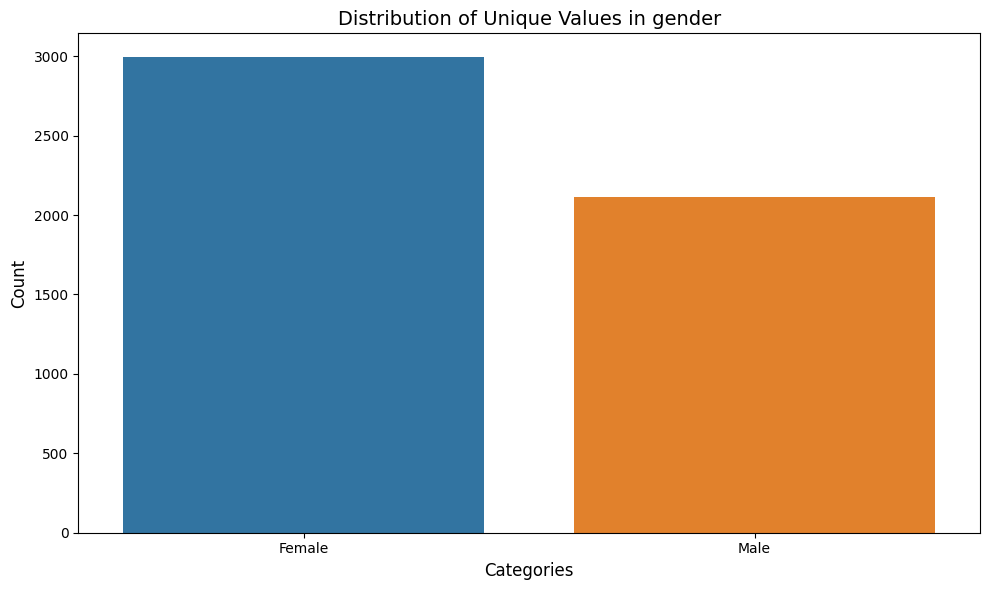

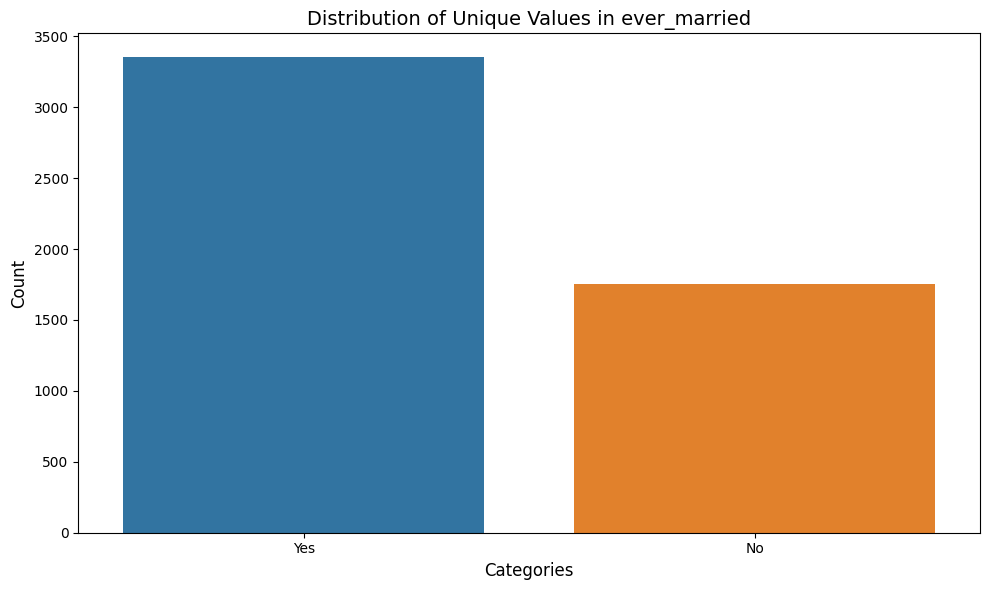

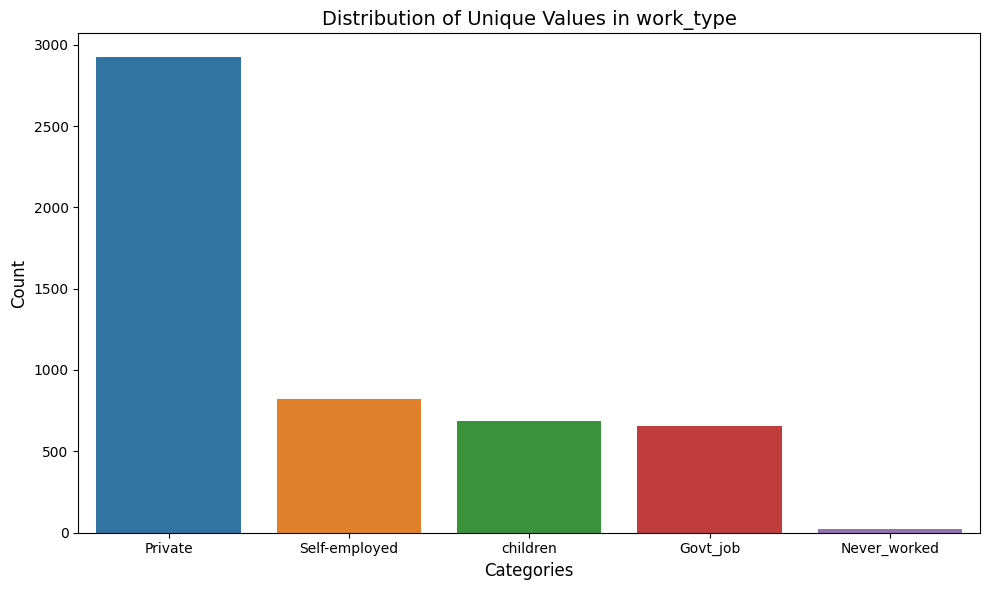

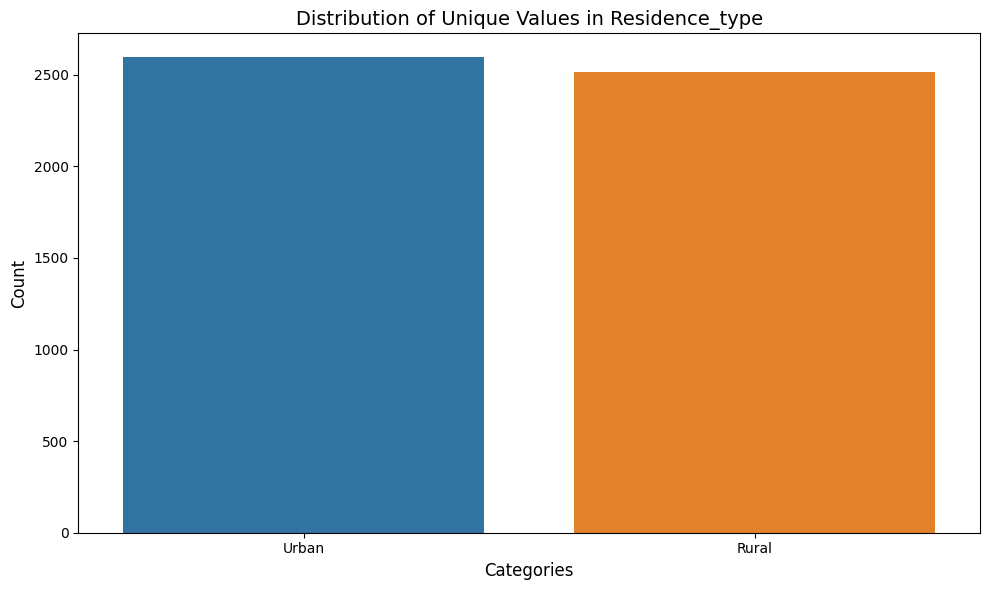

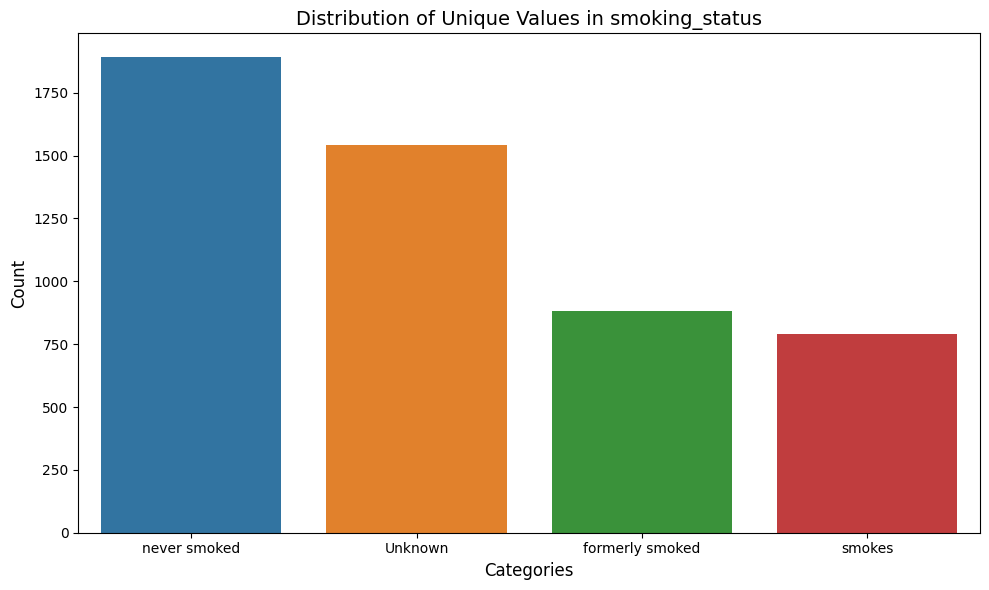

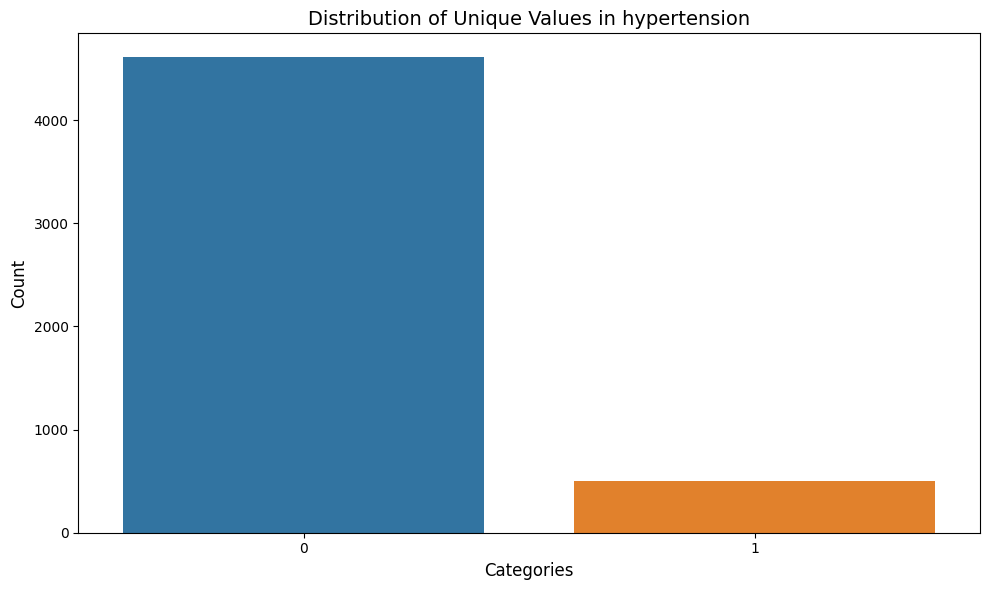

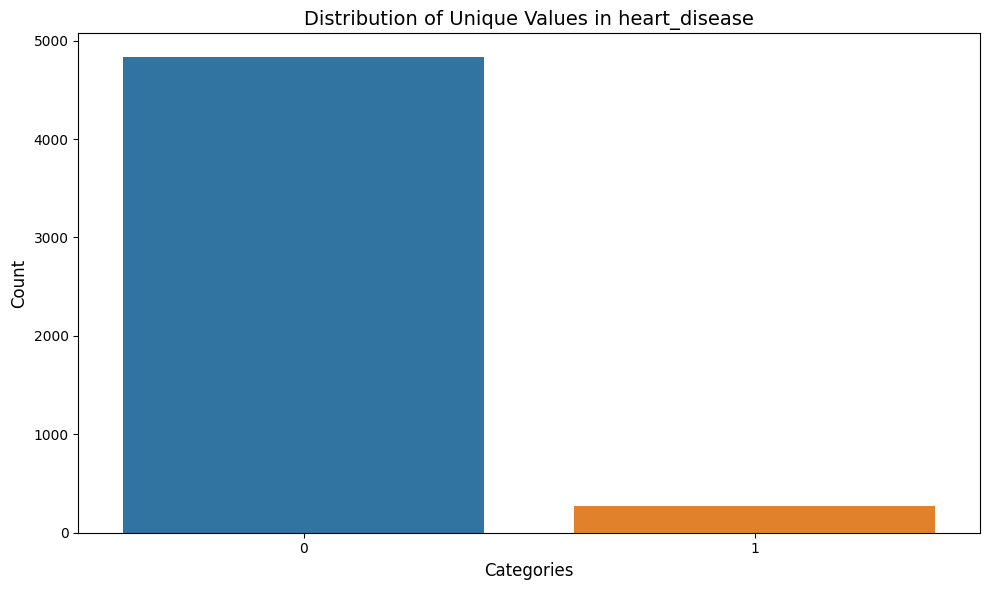

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of unique values for each categorical variable
for column in categorical_columns:
    plt.figure(figsize=(10, 6))
    value_counts = df[column].value_counts()
    sns.barplot(x=value_counts.index, y=value_counts.values)
    plt.title(f'Distribution of Unique Values in {column}', fontsize=14)
    plt.xlabel('Categories', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(fontsize=10)
    plt.tight_layout()
    plt.show()

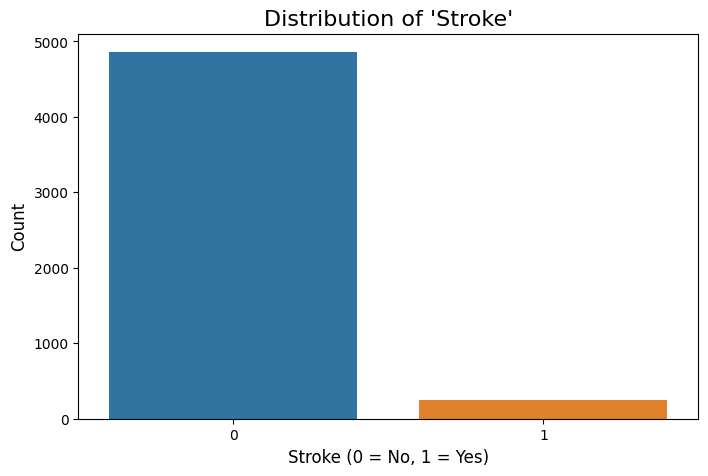

In [12]:
# Plot the distribution of 'stroke'
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='stroke')
plt.title("Distribution of 'Stroke'", fontsize=16)
plt.xlabel("Stroke (0 = No, 1 = Yes)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()


## Numerical Feature Distribution

In [13]:
numerical_columns = df.drop(columns=categorical_columns.columns.tolist() + ['stroke'])

In [14]:
numerical_columns.head()

,age,avg_glucose_level,bmi
0,67.0,228.69,36.6
1,61.0,202.21,NaN
2,80.0,105.92,32.5
3,49.0,171.23,34.4
4,79.0,174.12,24.0


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


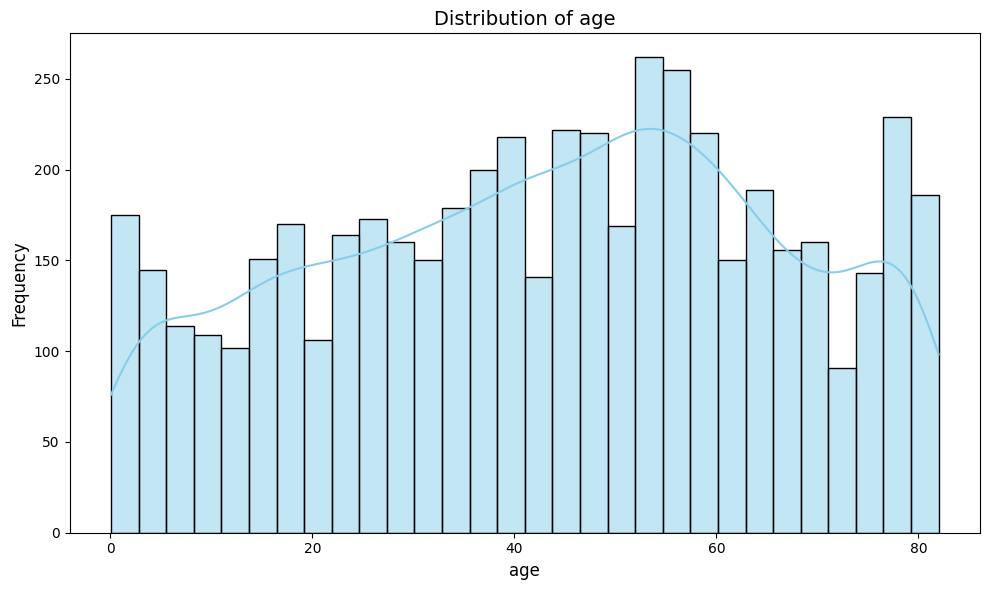

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


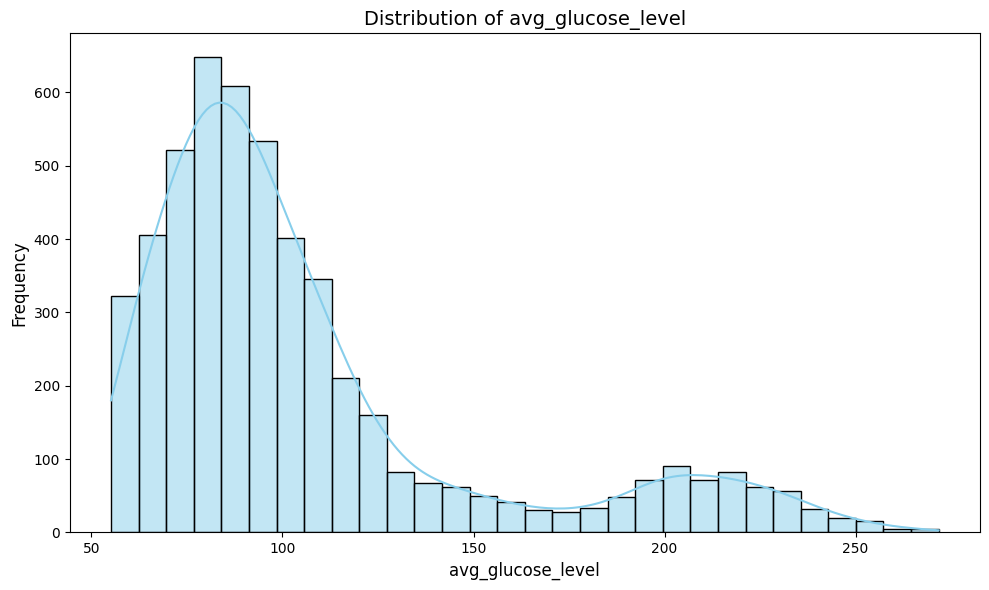

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


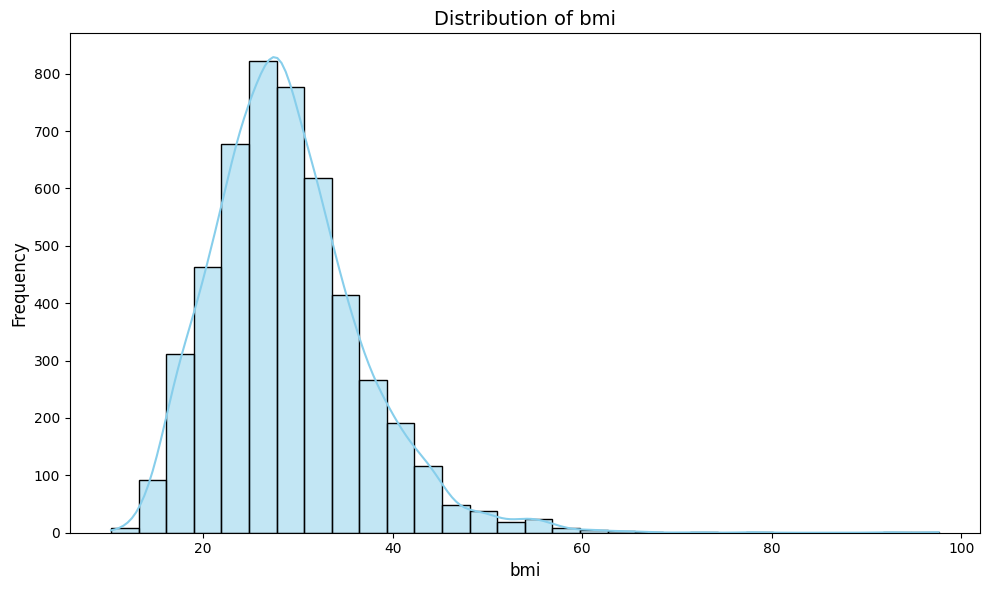

In [15]:
# Plot the distribution of each numerical variable
for column in numerical_columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(df[column], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {column}', fontsize=14)
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.tight_layout()
    plt.show()


In [16]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


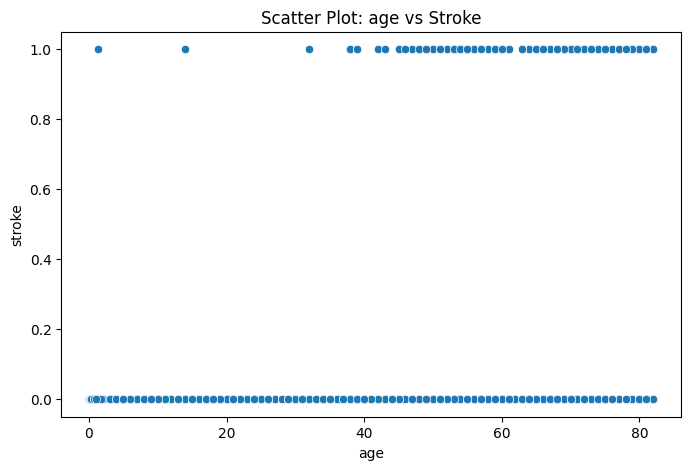

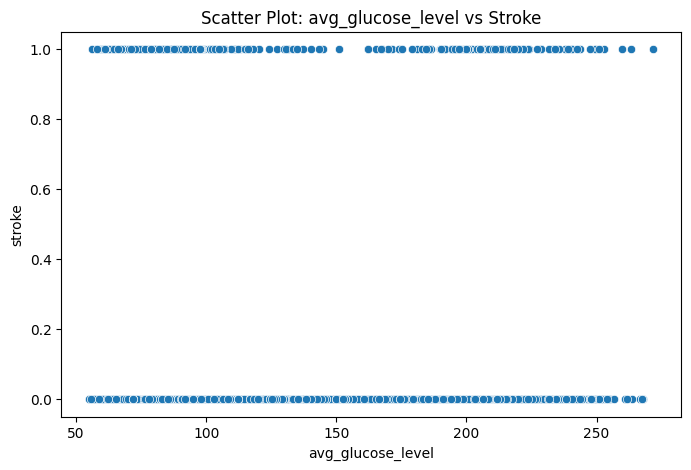

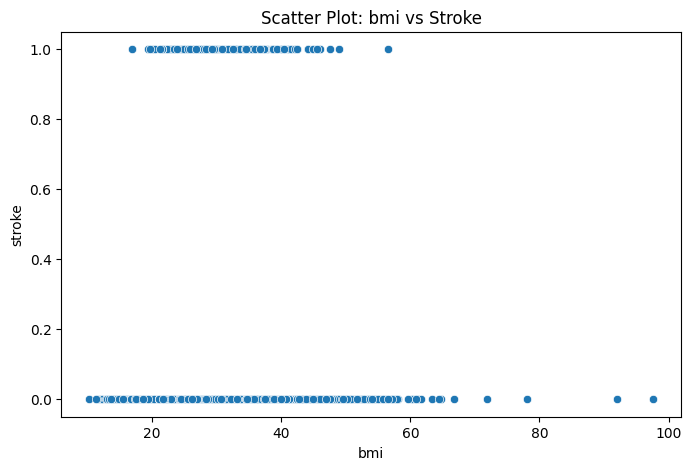

In [17]:
for column in numerical_columns:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=df, x=column, y='stroke')
    plt.title(f"Scatter Plot: {column} vs Stroke")
    plt.show()

## Train/Test Split

Define 'X' and 'y'.

In [18]:
X = df.drop(columns=['stroke'])  
y = df['stroke']  

Split the dataframe.

In [19]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1000, stratify=y
)

## Feature Engineering

### Binarize 'age' into Categories

Stroke risk increases with age, but the relationship is unlikely to be linear in nature. Binning age into categories can improve results.

In [20]:
# # Binarize age into categories
# X_train['age_group'] = pd.cut(X_train['age'], bins=[0, 30, 50, 70, 100], labels=['0-30', '30-50', '50-70', '70+'], right=False)
# X_test['age_group'] = pd.cut(X_test['age'], bins=[0, 30, 50, 70, 100], labels=['0-30', '30-50', '50-70', '70+'], right=False)

# # One-hot encode the new categorical feature into binary (0 or 1) columns
# X_train = pd.get_dummies(X_train, columns=['age_group'], drop_first=True, dtype=int)
# X_test = pd.get_dummies(X_test, columns=['age_group'], drop_first=True, dtype=int)

# # Drop the age column 
# X_train = X_train.drop(columns=['age'])
# X_test = X_test.drop(columns=['age'])

### Age and BMI Interaction Feature

In [21]:
# Create interaction feature for hypertension and heart disease
X_train['hypertension_heart_disease'] = X_train['hypertension'] * X_train['heart_disease']
X_test['hypertension_heart_disease'] = X_test['hypertension'] * X_test['heart_disease']

### Hypertension and Heart Disease Interaction Feature

Hypertension and heart disease are both predictors of stroke. An interaction term could capture their combined effect.

In [22]:
# Create interaction feature for hypertension and heart disease
X_train['hypertension_heart_disease'] = X_train['hypertension'] * X_train['heart_disease']
X_test['hypertension_heart_disease'] = X_test['hypertension'] * X_test['heart_disease']

### Log-Transform avg_glucose_level

Glucose levels may have a nonlinear relationship with stroke risk. Log transformation can normalize these skewed distributions.

In [23]:
# Log-transform avg_glucose_level
X_train['log_avg_glucose_level'] = np.log1p(X_train['avg_glucose_level'])
X_test['log_avg_glucose_level'] = np.log1p(X_test['avg_glucose_level'])

# Drop the avg_glucose_level column 
X_train = X_train.drop(columns=['avg_glucose_level'])
X_test = X_test.drop(columns=['avg_glucose_level'])

### Impute missing values of 'bmi' in the Test and Train data.

Missing values in the 'bmi' column can be imputed based on related features like smoking status and gender.

In [24]:
# Group by relevant features and calculate median/mean for BMI
grouped_median = X_train.groupby(['gender', 'smoking_status'])['bmi'].median()

# Function to impute missing BMI values based on grouped median
def impute_bmi(data, grouped_median):
    for (gender, smoking_status), median_value in grouped_median.items():
        mask = (data['gender'] == gender) & (data['smoking_status'] == smoking_status) & (data['bmi'].isnull())
        data.loc[mask, 'bmi'] = median_value
    return data

# Impute BMI in training data
X_train = impute_bmi(X_train, grouped_median)

# Impute BMI in test data using training grouped median
X_test = impute_bmi(X_test, grouped_median)

### Age and BMI Interaction Feature

In [25]:
# Add the 'age*bmi' feature to the train and test sets
X_train['age*bmi'] = X_train['age'] * X_train['bmi']
X_test['age*bmi'] = X_test['age'] * X_test['bmi']

### Create a BMI Risk Group

Convert BMI into categories based on clinical thresholds (e.g., underweight, normal, overweight, obese).

In [26]:
# # Binarize BMI into risk groups
# X_train['bmi_category'] = pd.cut(X_train['bmi'], bins=[0, 18.5, 24.9, 29.9, np.inf], labels=['Underweight', 'Normal', 'Overweight', 'Obese'])
# X_test['bmi_category'] = pd.cut(X_test['bmi'], bins=[0, 18.5, 24.9, 29.9, np.inf], labels=['Underweight', 'Normal', 'Overweight', 'Obese'])

# # One-hot encode the new categorical feature
# X_train = pd.get_dummies(X_train, columns=['bmi_category'], drop_first=True)
# X_test = pd.get_dummies(X_test, columns=['bmi_category'], drop_first=True)

# # Drop the bmi column 
# X_train = X_train.drop(columns=['bmi'])
# X_test = X_test.drop(columns=['bmi'])


### Create Urban/Rural Interaction with Smoking Status

Urban living combined with smoking may introduce unique stroke risk factors.

In [27]:
# Interaction between residence type and smoking status
X_train['urban_smoker'] = (X_train['Residence_type'] == 'Urban') & (X_train['smoking_status'] == 'smokes')
X_test['urban_smoker'] = (X_test['Residence_type'] == 'Urban') & (X_test['smoking_status'] == 'smokes')

# Convert boolean to integer
X_train['urban_smoker'] = X_train['urban_smoker'].astype(int)
X_test['urban_smoker'] = X_test['urban_smoker'].astype(int)

### More Interaction Features with Glucose Levels

I will create interaction terms for potentially meaningful combinations:
* **age * log_avg_glucose_level**: Captures combined effects of age and glucose levels on stroke risk.
* **hypertension_heart_disease * log_avg_glucose_level**: Tests if glucose amplifies the risk for patients with comorbidities.

In [28]:
# Add interaction features to the train set
X_train['age*log_avg_glucose_level'] = X_train['age'] * X_train['log_avg_glucose_level']
X_train['hhd*glucose'] = (
    X_train['hypertension_heart_disease'] * X_train['log_avg_glucose_level']
)

# Add interaction features to the test set
X_test['age*log_avg_glucose_level'] = X_test['age'] * X_test['log_avg_glucose_level']
X_test['hhd*glucose'] = (
    X_test['hypertension_heart_disease'] * X_test['log_avg_glucose_level']
)

### One-Hot Encoding

In [29]:
from sklearn.preprocessing import OneHotEncoder

# Features to one-hot encode
one_hot_features = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

# Example: Providing all possible categories manually
all_categories = [
    ['Male', 'Female'],  # gender
    ['Yes', 'No'],               # ever_married
    ['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked'],  # work_type
    ['Urban', 'Rural'],          # Residence_type
    ['formerly smoked', 'never smoked', 'smokes', 'Unknown']  # smoking_status
]

encoder = OneHotEncoder(categories=all_categories, sparse_output=False, drop='first')

# Fit and transform the training data
X_train_encoded = encoder.fit_transform(X_train[one_hot_features])

# Transform the test data
X_test_encoded = encoder.transform(X_test[one_hot_features])

# Convert encoded arrays back to DataFrames
encoded_feature_names = encoder.get_feature_names_out(one_hot_features)
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoded_feature_names, index=X_train.index)
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoded_feature_names, index=X_test.index)

# Drop original categorical columns and add the encoded columns
X_train = X_train.drop(columns=one_hot_features).join(X_train_encoded_df)
X_test = X_test.drop(columns=one_hot_features).join(X_test_encoded_df)

## SMOTE

In [30]:
# Check the new class distribution before SMOTE
print("Class Distribution Before SMOTE:\n", y_train.value_counts())

Class Distribution Before SMOTE:
 stroke
0    3888
1     199
Name: count, dtype: int64


In [31]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance the training set
smote = SMOTE(random_state=1000)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [32]:
# Check the new class distribution after SMOTE
print("Class Distribution After SMOTE:\n", y_train.value_counts())

Class Distribution After SMOTE:
 stroke
0    3888
1    3888
Name: count, dtype: int64


## Scale Data

In [33]:
X_train.head()

,age,hypertension,heart_disease,bmi,hypertension_heart_disease,log_avg_glucose_level,age*bmi,urban_smoker,age*log_avg_glucose_level,hhd*glucose,gender_Female,ever_married_No,work_type_Self-employed,work_type_Govt_job,work_type_children,work_type_Never_worked,Residence_type_Rural,smoking_status_never smoked,smoking_status_smokes,smoking_status_Unknown
0,2.0,0,0,18.1,0,4.745106,36.2,0,9.490212,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,50.0,0,0,18.7,0,4.261552,935.0,0,213.077624,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,51.0,0,0,32.3,0,4.519394,1647.3,0,230.489115,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,53.0,0,0,23.3,0,4.378646,1234.9,0,232.068234,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
4,79.0,1,0,28.7,0,4.452951,2267.3,0,351.783127,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
from sklearn.preprocessing import StandardScaler

# Initialize StandardScaler
scaler = StandardScaler()

# Identify numerical columns
numerical_columns = ['age', 'log_avg_glucose_level', 'bmi', 'age*bmi',
                     'age*log_avg_glucose_level', 'hhd*glucose']  
# numerical_columns = ['age', 'avg_glucose_level', 'bmi']  

# Scale numerical features in training data
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])

# Scale numerical features in testing data
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

In [35]:
print(set(numerical_columns) - set(X_train.columns))

set()


In [36]:
X_train.head()

,age,hypertension,heart_disease,bmi,hypertension_heart_disease,log_avg_glucose_level,age*bmi,urban_smoker,age*log_avg_glucose_level,hhd*glucose,gender_Female,ever_married_No,work_type_Self-employed,work_type_Govt_job,work_type_children,work_type_Never_worked,Residence_type_Rural,smoking_status_never smoked,smoking_status_smokes,smoking_status_Unknown
0,-2.367403,0,0,-1.633732,0,0.145433,-2.178873,0,-2.231772,-0.207678,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,-0.213621,0,0,-1.547310,0,-1.116883,-0.957953,0,-0.412255,-0.207678,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.168751,0,0,0.411603,0,-0.443787,0.009628,0,-0.256644,-0.207678,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,-0.079010,0,0,-0.884736,0,-0.811211,-0.550572,0,-0.242531,-0.207678,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
4,1.087622,1,0,-0.106933,0,-0.617238,0.851829,0,0.827394,-0.207678,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Undersampling

In [37]:
from imblearn.under_sampling import RandomUnderSampler

# Apply undersampling to the training data
undersampler = RandomUnderSampler(random_state=1000)
X_train, y_train = undersampler.fit_resample(X_train, y_train)

## Feature Selection

- Feature Selection will use methods like mutual information, recursive feature elimination (RFE), or Lasso regression to identify important predictors.
- PCA (Principal Component Analysis): If dimensionality reduction is necessary.

### Mutual Information

In [38]:
from sklearn.feature_selection import mutual_info_classif

# Compute mutual information on the training data
mi_scores = mutual_info_classif(X_train, y_train, discrete_features='auto')

# Create a DataFrame for better visualization
mi_scores_df = pd.Series(mi_scores, index=X_train.columns).sort_values(ascending=False)
print(mi_scores_df)


age                            0.527833
bmi                            0.444719
age*bmi                        0.227455
age*log_avg_glucose_level      0.216666
Residence_type_Rural           0.193968
gender_Female                  0.190137
ever_married_No                0.168901
smoking_status_never smoked    0.167564
work_type_Self-employed        0.144719
smoking_status_Unknown         0.128489
smoking_status_smokes          0.106468
work_type_Govt_job             0.086657
log_avg_glucose_level          0.042299
work_type_children             0.041185
hhd*glucose                    0.030540
urban_smoker                   0.013495
hypertension_heart_disease     0.003775
heart_disease                  0.000354
hypertension                   0.000000
work_type_Never_worked         0.000000
dtype: float64


### RFE

In [39]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

# Initialize the model
model = RandomForestClassifier(random_state=1000)

# Apply RFE to the training set
rfe = RFE(estimator=model, n_features_to_select=5)  # Select the top 5 features
X_train_rfe = rfe.fit_transform(X_train, y_train)

# Transform the test set using the same RFE object
X_test_rfe = rfe.transform(X_test)

# Get the selected feature names
selected_features = X_train.columns[rfe.support_]
print("Selected Features:", selected_features)


Selected Features: Index(['age', 'age*bmi', 'age*log_avg_glucose_level',
       'work_type_Self-employed', 'Residence_type_Rural'],
      dtype='object')


### Pair Plot

In [40]:
# sns.pairplot(pd.concat([X_train, y_train], axis=1), hue='stroke', diag_kind='kde', palette='coolwarm')
# plt.suptitle("Pair Plot of Features and Target", y=1.02, fontsize=16)
# plt.savefig("pairplot.png", dpi=300, bbox_inches='tight')  # Save as PNG
# plt.show()

### Observations from the Pairplot

#### **1. Feature Distributions**
- The diagonal plots show the distribution (histograms or KDE plots) for individual features.
- Features like `age`, `log_avg_glucose_level`, and `bmi` have varying distributions:
  - `age` appears to be right-skewed, with a concentration of values in younger demographics.
  - `log_avg_glucose_level` shows a wider spread, indicating variability in glucose levels.
  - `bmi` distribution is fairly balanced but with a few outliers at higher values.

#### **2. Correlations Between Features**
- **Linear Relationships**:
  - Some pairwise relationships between numerical features appear linear. For example:
    - `age` and `ever_married_No` exhibit a negative linear relationship, which aligns with the expectation that younger individuals are less likely to be married.
  - Other features like `bmi` and `age` show weaker relationships.
  
- **No Clear Relationship**:
  - Many pairwise scatterplots show no discernible relationship (e.g., between `bmi` and `log_avg_glucose_level`).

#### **3. Outliers**
- Certain features, such as `log_avg_glucose_level` and `bmi`, show potential outliers.
  - Outliers in `log_avg_glucose_level` could disproportionately affect the model if not addressed.

#### **4. Target Variable (`stroke`)**
- The target variable's separation is not explicitly shown here but can be incorporated by using hue in pairplots to identify patterns by class.

---

### Suggestions for Improvements

#### **1. Add `stroke` as Hue for Class Separation**
- Incorporating the `stroke` target variable as a `hue` parameter in the pairplot will help visualize differences between classes.
  
  **Example Code**:
  ```python
  import seaborn as sns
  sns.pairplot(data=df, hue='stroke', diag_kind='kde', palette='coolwarm')
  ```

#### **2. Handle Outliers**
- Investigate and handle outliers in features like `log_avg_glucose_level` and `bmi` using:
  - Clipping extreme values.
  - Transformations like logarithms.

#### **3. Use Interaction Terms**
- Some weak pairwise relationships might become more significant if interaction terms are created.
  - Example: Interaction between `age` and `bmi`.

#### **4. Simplify Features**
- Some features may not contribute meaningfully to the target variable (`stroke`) and can be removed to simplify the dataset.
  - For example, features with no discernible patterns in their pairwise plots.

#### **5. Normalize/Scale Features**
- Features like `age`, `log_avg_glucose_level`, and `bmi` have different scales, which may impact the performance of certain models (e.g., Logistic Regression, SVM).

---

### Summary
- The pairplot highlights key distributions, weak or absent correlations between features, and potential outliers.
- Adding `hue='stroke'` to the plot would help visualize how features contribute to class separation.
- Addressing outliers and considering feature interactions or transformations could improve model performance.

Let me know if you'd like to refine the pairplots or analyze specific features further!

### Correlation Matrix

In [41]:
matrix_list = X_train.corrwith(y_train.squeeze())
print(matrix_list.sort_values(ascending=False))

age*log_avg_glucose_level      0.589250
age                            0.584735
age*bmi                        0.510491
log_avg_glucose_level          0.245828
work_type_Self-employed        0.142922
hhd*glucose                    0.141515
bmi                            0.083614
smoking_status_smokes          0.049878
smoking_status_never smoked    0.019808
heart_disease                  0.004202
work_type_Govt_job            -0.006844
Residence_type_Rural          -0.019067
hypertension                  -0.019434
gender_Female                 -0.021403
hypertension_heart_disease    -0.023136
work_type_Never_worked        -0.049491
smoking_status_Unknown        -0.156863
urban_smoker                  -0.167826
work_type_children            -0.265079
ever_married_No               -0.299610
dtype: float64


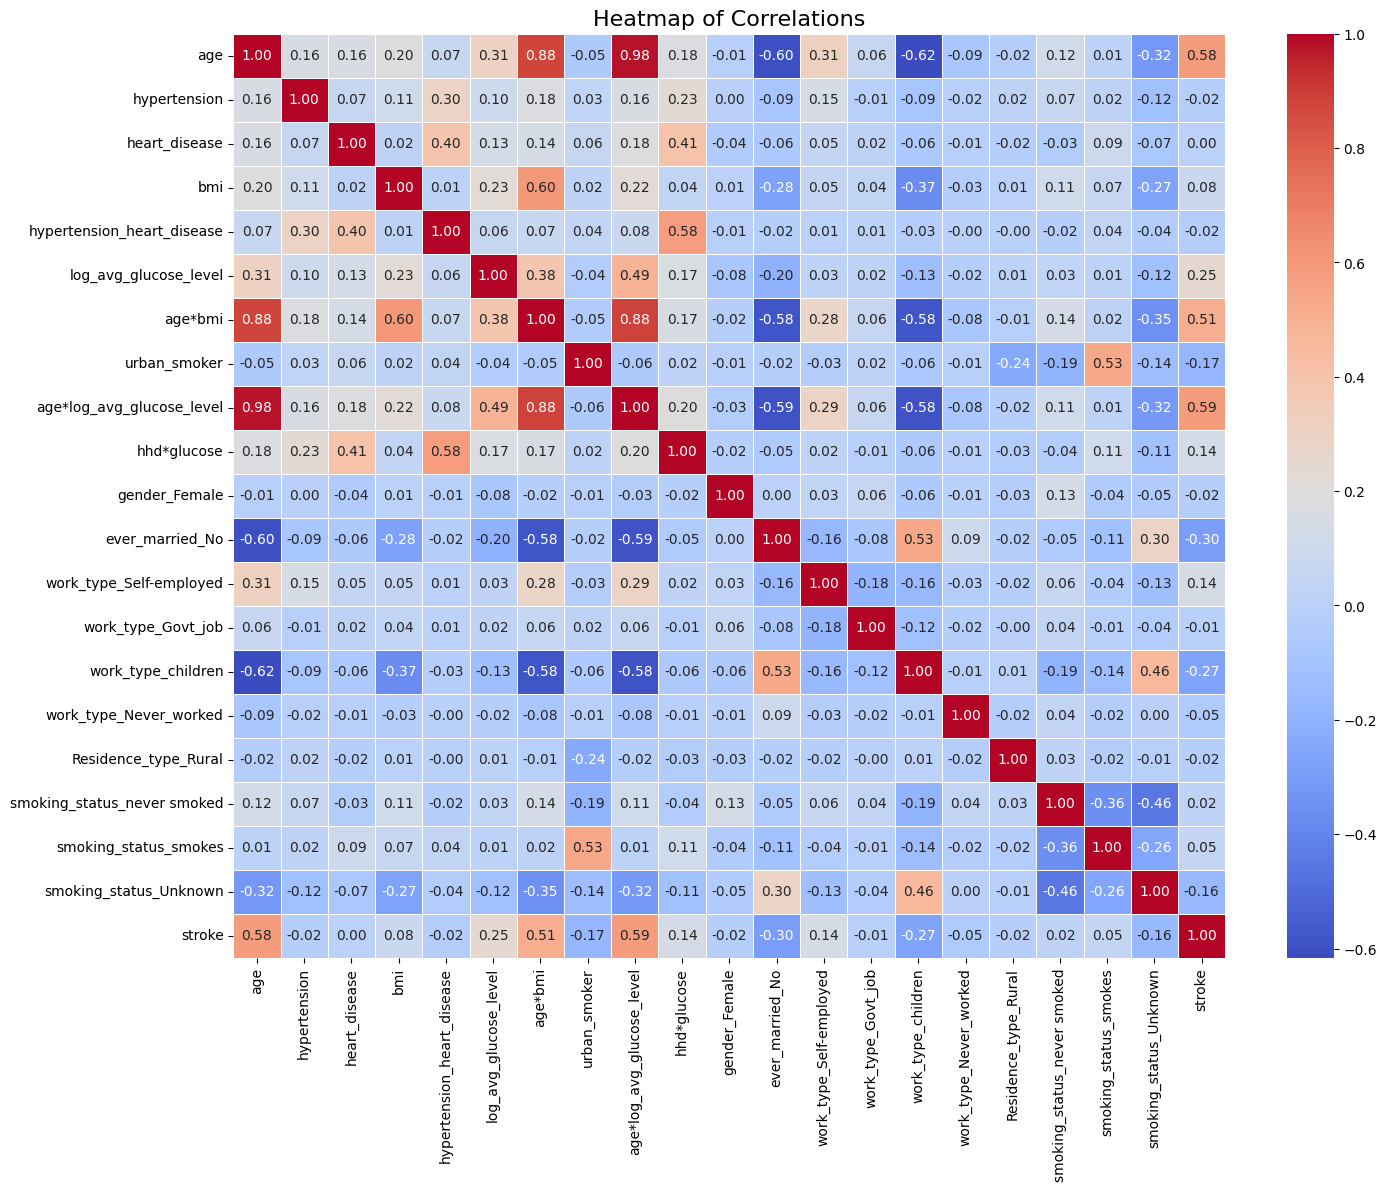

In [42]:
# Correlation matrix
correlation_matrix = pd.concat([X_train, y_train], axis=1).corr()

# Heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Heatmap of Correlations", fontsize=16)
plt.savefig("heatmap.png", dpi=300, bbox_inches='tight')  # Save as PNG
plt.show()

### Observations from the Heatmap

### **1. Correlation with the Target (`stroke`)**
- **Key Predictors**:
  - `age` has the strongest positive correlation with `stroke` (~0.60), reaffirming that older individuals are at higher risk of stroke.
  - `log_avg_glucose_level` shows a moderate correlation (~0.22), suggesting glucose levels may be associated with stroke risk.
  - `work_type_Self-employed` (~0.16) shows a smaller, yet noticeable, positive correlation with `stroke`.

- **Weak/Negative Correlations**:
  - Features like `smoking_status_smokes` (-0.17) and `work_type_children` (-0.27) exhibit weak or negative correlations, suggesting limited direct influence on `stroke`.

---

### **2. Multicollinearity**
- **Highly Correlated Features**:
  - `age` and `ever_married_No` are strongly negatively correlated (~-0.59), as younger individuals are less likely to be married.
  - `work_type_children` and `age` are negatively correlated (~-0.61), which is expected given the association of "children" with younger demographics.
  - `bmi` and `bmi_category_Obese` have a strong positive correlation (~0.75), indicating redundancy due to feature binning.

- **Implication**:
  - Multicollinearity between features can affect models like Logistic Regression. Removing redundant features (e.g., either `bmi` or `bmi_category_*`) can simplify the model and improve performance.

---

### **3. Low or Irrelevant Correlations**
- Features like `gender_Female` (~0.03), `Residence_type_Rural` (~0.01), and `work_type_Never_worked` (~0.00) show almost no correlation with `stroke`.
- These features might not significantly contribute to predicting stroke and could be considered for removal to reduce noise and dimensionality.

---

### **4. Feature Interactions**
- Some features may have weak individual correlations but could contribute through interactions. For instance:
  - Interaction between `age` and `log_avg_glucose_level` may capture combined risk factors for stroke.
  - Combining `hypertension` and `heart_disease` (already represented as `hypertension_heart_disease`) provides a stronger signal than either feature individually.

---

### Recommendations

#### **1. Remove Redundant or Low-Impact Features**
- Drop features with very low correlations with the target (e.g., `Residence_type_Rural`, `gender_Female`) to simplify the dataset.
- Drop highly redundant features, such as either `bmi` or `bmi_category_*`.

#### **2. Handle Multicollinearity**
- For features with high correlation, such as `age` and `ever_married_No`, consider keeping only one to avoid multicollinearity in linear models.

#### **3. Engineer Interaction Terms**
- Create interaction terms for potentially meaningful combinations:
  - `age * log_avg_glucose_level`: Captures combined effects of age and glucose levels on stroke risk.
  - `hypertension_heart_disease * log_avg_glucose_level`: Tests if glucose amplifies the risk for patients with comorbidities.

#### **4. Test Tree-Based Models**
- Models like Random Forest or Gradient Boosting can handle multicollinearity and weak individual predictors better than linear models.

#### **5. Feature Scaling**
- Scale numerical features like `age`, `bmi`, and `log_avg_glucose_level` for models sensitive to feature magnitude, such as Logistic Regression or SVM.

---

### Next Steps
If you'd like, I can help refine the dataset based on these insights or provide code for implementing these recommendations. Let me know!

### Remove Rows

In [43]:
# Columns to remove
columns_to_remove = ['gender_Female', 'Residence_type_Rural', 
                     'work_type_Never_worked', 'ever_married_No']

# Drop the specified columns from the train and test sets
X_train = X_train.drop(columns=columns_to_remove)
X_test = X_test.drop(columns=columns_to_remove)

Features like gender_Female, Residence_type_Rural, and work_type_Never_worked show almost no correlation with stroke.

In [44]:
# Export DataFrame to a CSV file
X_train.to_csv('X_train.csv', index=False)
y_train.to_csv('y_train.csv', index=False)

# <span style="color:#5E6997">Predict Strokes</span> <a class="anchor" id="predict"></a>

## Define a Function to Evaluate Models
To avoid repeating this code for every model, I will define a reusable function:

In [45]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report, ConfusionMatrixDisplay

def evaluate_model_performance(model, X_test, y_test):
    # Predict probabilities for the positive class (required for AUC-ROC)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)

    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.2f})")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line for random guessing
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.show()

    # Print AUC
    print(f"AUC: {auc:.2f}")

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate the model with confusion matrix and classification report
    conf_matrix = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, zero_division=1)

    # Print report
    print("\nClassification Report:")
    print(report)

    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot as heatmap
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Stroke', 'Stroke'])
    disp.plot(cmap='Blues', values_format='d')
    plt.title("Confusion Matrix Heatmap")
    plt.show()


## Logistic Regression

#### Base Model

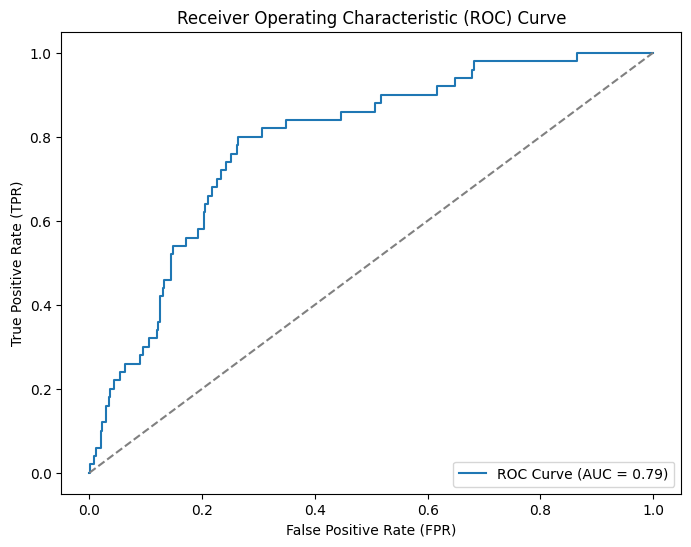

AUC: 0.79

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.76      0.86       972
           1       0.14      0.72      0.23        50

    accuracy                           0.76      1022
   macro avg       0.56      0.74      0.54      1022
weighted avg       0.94      0.76      0.83      1022



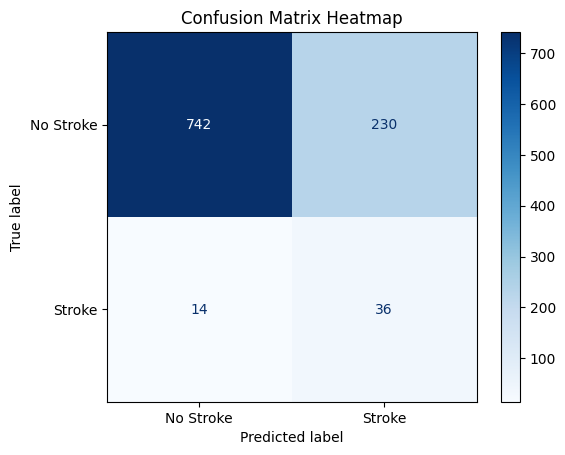

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay

# Train the logistic regression model
# Train logistic regression with increased iterations 
logreg = LogisticRegression(
    class_weight='balanced',
    random_state=1000, 
    max_iter=1000, 
    solver='lbfgs'  # You can try 'saga' or 'liblinear' if issues persist
)
logreg.fit(X_train, y_train)

#Evaluate the model
evaluate_model_performance(logreg, X_test, y_test)

#### Tuned Model

In [47]:
# from sklearn.model_selection import GridSearchCV

# # Define the model
# logreg = LogisticRegression(class_weight='balanced', random_state=1000, max_iter=1000)

# # Define a valid hyperparameter grid
# param_grid = [
#     {
#         'penalty': ['l2', 'none'],  # For lbfgs
#         'solver': ['lbfgs'],
#         'C': [0.01, 0.1, 1, 10, 100]
#     },
#     {
#         'penalty': ['l1', 'l2'],  # For liblinear
#         'solver': ['liblinear'],
#         'C': [0.01, 0.1, 1, 10, 100]
#     },
#     {
#         'penalty': ['l1', 'l2', 'elasticnet'],  # For saga
#         'solver': ['saga'],
#         'C': [0.01, 0.1, 1, 10, 100],
#         'l1_ratio': [0.5, 0.7, 0.9]  # Only for elasticnet
#     }
# ]

# # Perform Grid Search
# grid_search = GridSearchCV(
#     estimator=logreg,
#     param_grid=param_grid,
#     scoring='roc_auc',
#     cv=5,
#     n_jobs=-1,
#     verbose=2
# )

# # Fit the grid search
# grid_search.fit(X_train, y_train)

# # Get the best model and hyperparameters
# best_model = grid_search.best_estimator_
# best_params = grid_search.best_params_
# best_score = grid_search.best_score_

# print("Best Hyperparameters:", best_params)
# print(f"Best Cross-Validation AUC Score: {best_score:.3f}")

# # Evaluate the best model
# print("\nEvaluating the best model on the test set:")
# evaluate_model_performance(best_model, X_test, y_test)

**Logistic Regression Best Results**

* Fitting 5 folds for each of 65 candidates, totalling 325 fits
* Best Hyperparameters: {'C': 100, 'l1_ratio': 0.5, 'penalty': 'elasticnet', 'solver': 'saga'}
* Best Cross-Validation AUC Score: 0.889

AUC: 0.77

Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.79      0.87       972
           1       0.12      0.54      0.19        50

    accuracy                           0.78      1022
    macro avg       0.54      0.67     0.53      1022
    weighted avg    0.93      0.78     0.84      1022

## Random Forest Model

#### Base Model

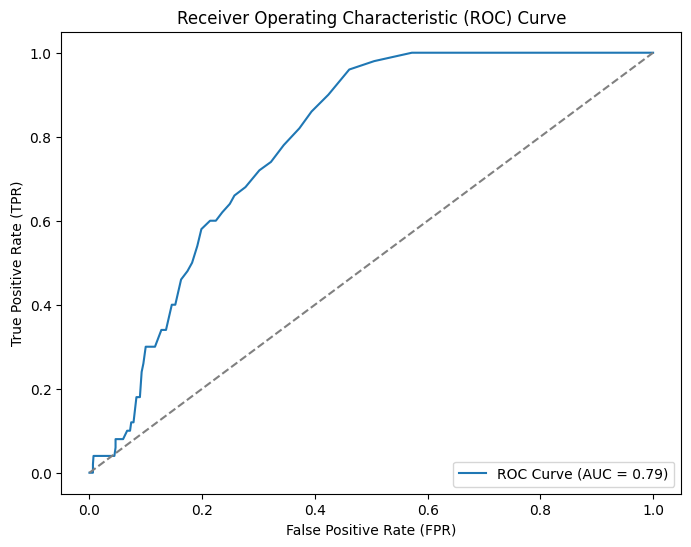

AUC: 0.79

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       972
           1       0.06      0.04      0.05        50

    accuracy                           0.92      1022
   macro avg       0.50      0.50      0.50      1022
weighted avg       0.91      0.92      0.91      1022



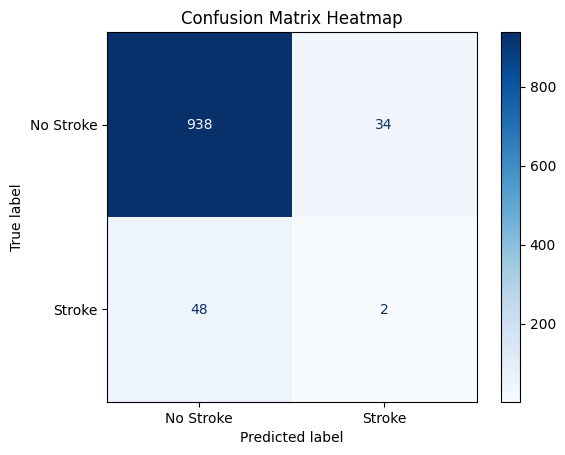

In [48]:
from sklearn.ensemble import RandomForestClassifier

# Train a base Random Forest model
rf_model = RandomForestClassifier(random_state=1000, class_weight='balanced')  # Handle class imbalance
rf_model.fit(X_train, y_train)

#Evaluate the model
evaluate_model_performance(rf_model, X_test, y_test)

#### Tuned Model

In [49]:
# from sklearn.model_selection import GridSearchCV

# # Define the Random Forest model
# rf_model = RandomForestClassifier(random_state=1000, class_weight='balanced')

# # Define the hyperparameter grid
# param_grid = {
#     'n_estimators': [100, 200, 500],  # Number of trees in the forest
#     'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
#     'min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
#     'min_samples_leaf': [1, 2, 4],  # Minimum samples required to be at a leaf node
#     'max_features': ['sqrt', 'log2', None],  # Number of features to consider at each split
#     'bootstrap': [True, False]  # Whether bootstrap samples are used
# }

# # Perform GridSearchCV
# grid_search = GridSearchCV(
#     estimator=rf_model,
#     param_grid=param_grid,
#     scoring='roc_auc',  # Use AUC as the scoring metric
#     cv=5,  # 5-fold cross-validation
#     n_jobs=-1,  # Use all available CPUs
#     verbose=2
# )

# # Fit the grid search to the training data
# grid_search.fit(X_train, y_train)

# # Retrieve the best model and hyperparameters
# best_rf_model = grid_search.best_estimator_
# best_params = grid_search.best_params_
# best_score = grid_search.best_score_

# # Print the best parameters and cross-validation AUC score
# print("Best Hyperparameters:", best_params)
# print(f"Best Cross-Validation AUC Score: {best_score:.3f}")

# # Evaluate the best model on the test set
# print("\nEvaluating the best Random Forest model on the test set:")
# evaluate_model_performance(best_rf_model, X_test, y_test)

**Random Forest Best Results**
* Best Hyperparameters: {'bootstrap': False, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
* Best Cross-Validation AUC Score: 0.995

AUC: 0.76

Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       972
           1       0.11      0.04      0.06        50

    accuracy                           0.94      1022
    macro avg      0.53      0.51      0.51      1022
    weighted avg   0.91      0.94      0.92      1022

## Gradient Boosting Model

#### Base Model

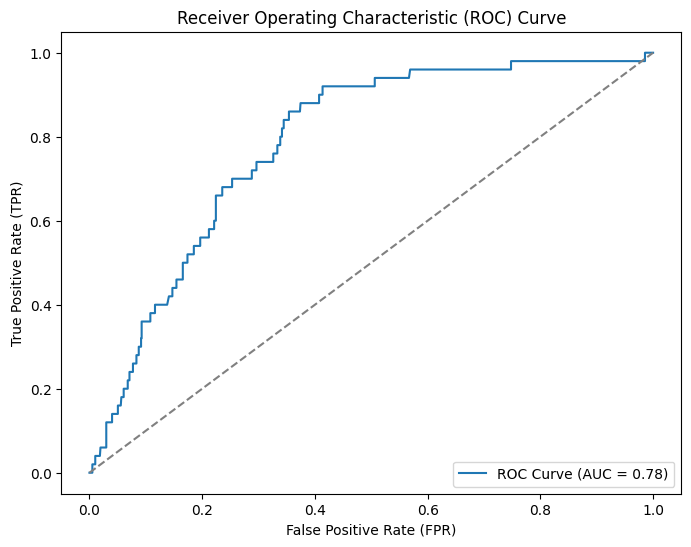

AUC: 0.78

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       972
           1       0.13      0.14      0.13        50

    accuracy                           0.91      1022
   macro avg       0.54      0.55      0.54      1022
weighted avg       0.92      0.91      0.91      1022



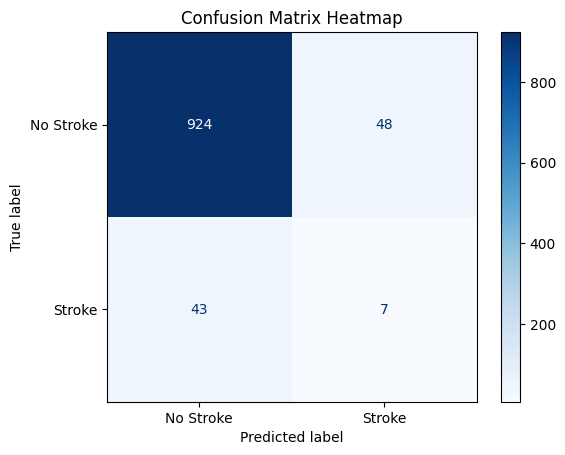

In [50]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize and train the Gradient Boosting model
gbm = GradientBoostingClassifier(random_state=1000)
gbm.fit(X_train, y_train)

#Evaluate the model
evaluate_model_performance(gbm, X_test, y_test)

#### Tuned Model

In [51]:
# from sklearn.model_selection import GridSearchCV

# # Define the Gradient Boosting model
# gbm = GradientBoostingClassifier(random_state=1000)

# # Define the hyperparameter grid
# param_grid = {
#     'n_estimators': [100, 200, 300],  # Number of boosting stages
#     'learning_rate': [0.01, 0.1, 0.2],  # Learning rate shrinks contribution of each tree
#     'max_depth': [3, 5, 7],  # Maximum depth of individual regression estimators
#     'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
#     'min_samples_leaf': [1, 2, 4],  # Minimum number of samples in a leaf
#     'subsample': [0.6, 0.8, 1.0],  # Fraction of samples used for fitting individual base learners
#     'max_features': ['sqrt', 'log2', None]  # Number of features considered for each split
# }

# # Perform GridSearchCV
# grid_search = GridSearchCV(
#     estimator=gbm,
#     param_grid=param_grid,
#     scoring='roc_auc',  # Optimize for AUC-ROC
#     cv=5,  # 5-fold cross-validation
#     n_jobs=-1,  # Use all available CPUs
#     verbose=2
# )

# # Fit the grid search to the training data
# grid_search.fit(X_train, y_train)

# # Retrieve the best model and hyperparameters
# best_gbm_model = grid_search.best_estimator_
# best_params = grid_search.best_params_
# best_score = grid_search.best_score_

# # Print the best parameters and cross-validation AUC score
# print("Best Hyperparameters:", best_params)
# print(f"Best Cross-Validation AUC Score: {best_score:.3f}")

# # Evaluate the best model on the test set
# print("\nEvaluating the best Gradient Boosting model on the test set:")
# evaluate_model_performance(best_gbm_model, X_test, y_test)

**Gradient Boosting Best Results**
* Best Hyperparameters: {'learning_rate': 0.2, 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300, 'subsample': 0.6}
* Best Cross-Validation AUC Score: 0.994

AUC: 0.78

Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       972
           1       0.09      0.04      0.06        50

    accuracy                           0.93      1022
    macro avg      0.52      0.51      0.51      1022
    weighted avg   0.91      0.93      0.92      1022

## Support Vector Machines (SVM) Model

#### Base Model

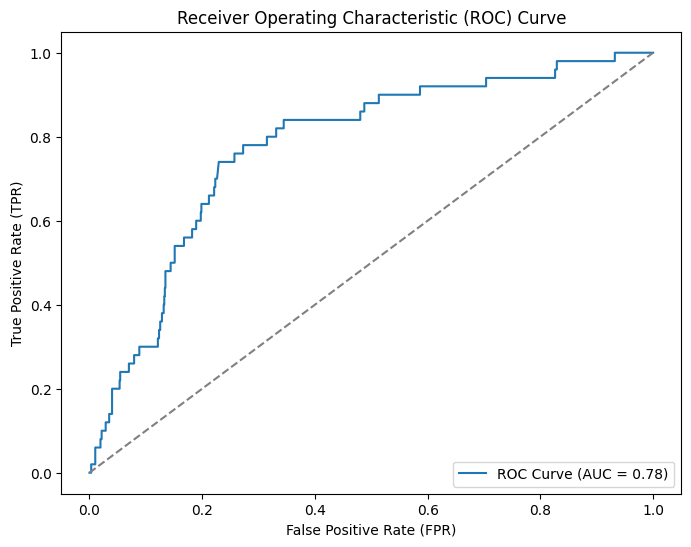

AUC: 0.78

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.77      0.86       972
           1       0.14      0.74      0.24        50

    accuracy                           0.77      1022
   macro avg       0.56      0.76      0.55      1022
weighted avg       0.94      0.77      0.83      1022



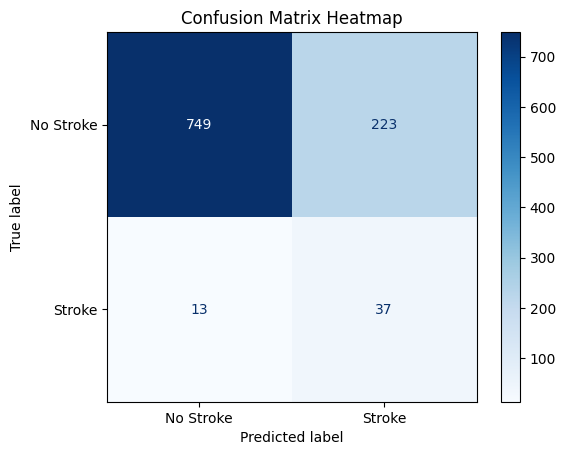

In [52]:
from sklearn.svm import SVC

# Train an SVM model with probability enabled
svm_model = SVC(kernel='linear', probability=True, random_state=1000, class_weight='balanced')
svm_model.fit(X_train, y_train)

#Evaluate the model
evaluate_model_performance(svm_model, X_test, y_test)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Hyperparameters: {'C': 0.01, 'gamma': 'scale', 'kernel': 'linear'}
Best Cross-Validation AUC Score: 0.869

Evaluating the best SVM model on the test set:


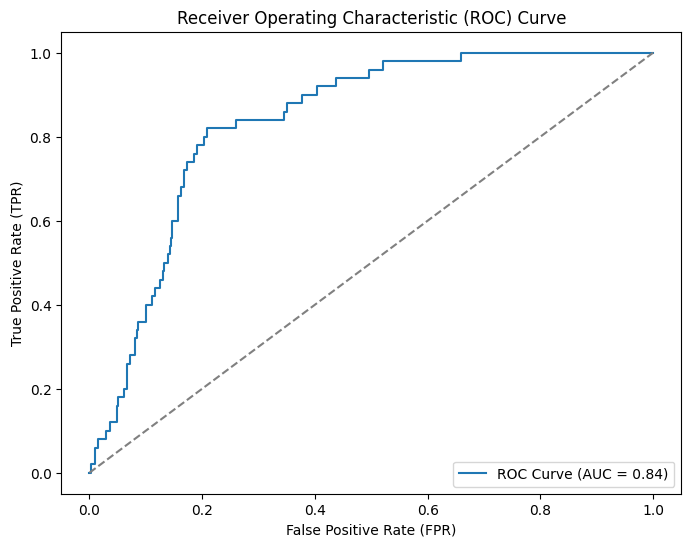

AUC: 0.84

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.73      0.84       972
           1       0.14      0.84      0.24        50

    accuracy                           0.73      1022
   macro avg       0.56      0.78      0.54      1022
weighted avg       0.95      0.73      0.81      1022



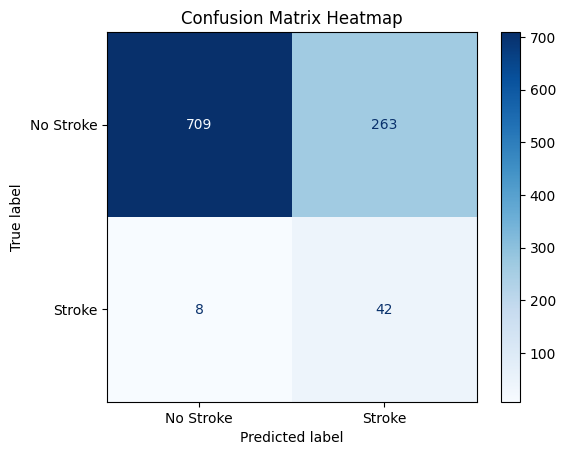

In [53]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

# Define the SVC model
svm_model = SVC(probability=True, random_state=1000, class_weight='balanced')

# Define the hyperparameter grid
param_grid = {
    'C': [0.01],  # Regularization parameter
    'kernel': ['linear', 'rbf'],  # Kernel type
    'gamma': ['scale', 'auto'],  # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
}

# Perform GridSearchCV
grid_search = GridSearchCV(
    estimator=svm_model,
    param_grid=param_grid,
    scoring='roc_auc',  # Optimize for AUC-ROC
    cv=StratifiedKFold(n_splits=5),  # Use StratifiedKFold
    n_jobs=-1,  # Use all available CPUs
    verbose=2
)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Retrieve the best model and hyperparameters
best_svm_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print the best parameters and cross-validation AUC score
print("Best Hyperparameters:", best_params)
print(f"Best Cross-Validation AUC Score: {best_score:.3f}")  

# Evaluate the best model on the test set using the default threshold
print("\nEvaluating the best SVM model on the test set:")
evaluate_model_performance(best_svm_model, X_test, y_test)

#### Tuned Model

**SVM Best Results**
* Best Hyperparameters: {'C': 0.01, 'gamma': 'scale', 'kernel': 'linear'}
* Best Cross-Validation AUC Score: 0.869

Evaluating the best SVM model on the test set:

AUC: 0.71

AUC: 0.84

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.73      0.84       972
           1       0.14      0.84      0.24        50

    accuracy                           0.73      1022
    macro avg      0.56      0.78      0.54      1022
    weighted avg   0.95      0.73      0.81      1022

# <span style="color:#5E6997">Conclusion</span> <a class="anchor" id="conclusion"></a>